#  m12m positioned at CenA
Find attached "image" file for m12m positioned at CenA! In this projection, the relative radial velocity for the bound remnant is +19 km/s. 

In [311]:
path = '/Users/spearson/Desktop/Research/FIREStreams/'
plot_path = '/Users/spearson/Desktop/Research/FIREStreams/plots/'

In [312]:
#imports to be used later on
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
from matplotlib.cm import get_cmap
from astropy.io import fits
import matplotlib
import scipy.ndimage
import scipy.interpolate
from astropy.table import Table
import astropy.units as u
%matplotlib inline

import math
import matplotlib.patches as patches

import random

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import gala.integrate as gi
from gala.units import galactic, UnitSystem

import astropy.coordinates as coord
from astropy.coordinates import SkyOffsetFrame 
from astropy.wcs import WCS
plt.ioff

from scipy.optimize import minimize

import reproject

from scipy.interpolate import interp1d

# Default gala cosmology: # WMAP7 cosmology in effect
from astropy import cosmology
cosmo = cosmology.default_cosmology.get()


# Import all the functions needed for fitting + stream generating etv
#import CenA_functions as CenA

In [313]:
mpl.rcParams.update({'font.size': 24})
label_size = 24
mpl.rcParams['xtick.labelsize'] = 22#label_size 
mpl.rcParams['ytick.labelsize'] =22 #label_size 

In [314]:
cena=coord.SkyCoord.from_name("CenA")

In [315]:
cena

<SkyCoord (ICRS): (ra, dec) in deg
    (201.365063, -43.019113)>

In [316]:
#generate grid for plotting sim data, centered on cen A +/- 3 deg
#dec_bins=np.linspace(cena.dec.deg-3, cena.dec.deg+3, 800)
#ra_bins=np.linspace(cena.ra.deg-3, cena.ra.deg+3, 800)

In [317]:
#dec_bins

In [318]:
#read in sim data 
h = np.load('m12m_cena_rot1.npy')


In [319]:
# flipping y-axis to make sure sim looks like Cen A data
h_new= np.flip(h, axis=0)

In [320]:
#h_new.shape

## Change header to make sim data appear like Cen A data

In [321]:
# just to get the same ICRS coordinates, read in header of Cen A data
path_CenA = '/Users/spearson/Desktop/Research/CenA/'
hdulist = fits.open(path_CenA + 'CenA_rgbmap_msolpc2.fits')
hdulist.info()
hdulist[0].data
hdr = dict(hdulist[0].header)
image = hdulist[0].data
wcs_input_dict = hdulist[0].header
wcs_helix_dict = WCS(wcs_input_dict)
header = hdulist[0].header
wcs_helix = WCS(header)

#getting rid of 0's from image data for imshow lognorm to work
# j = 0
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         if image[i,j] == 0.:
#             image[i,j] = 10**-10
#             j = j+1

Filename: /Users/spearson/Desktop/Research/CenA/CenA_rgbmap_msolpc2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (456, 424)   float64   


In [322]:
#hdulist[0].header

In [323]:
#print(799/456)
#print(799/424)

In [324]:
# trying to manipulate header to match sim data 
# first change pixle size
hdulist[0].header[3] = 799 # changing NAXIS1 (length of data axis 1) since sim data is different, was 456
hdulist[0].header[4] = 799 # changing NAXIS1 (length of data axis 1) since sim data is different, was 424

# now change Cen A location (center in sim)
hdulist[0].header[12] = 399
hdulist[0].header[13] = 399

#probably also need to change pixel scale values but will try this for now
hdulist[0].header[14] =  0.01/1.8 # was 0.01
hdulist[0].header[15]= 0.01/1.8 # was 0.01

In [325]:
#0.01/1.8

In [326]:
# now write the new wcs based on changes from sim
wcs_input_dict = hdulist[0].header
wcs_helix_dict = WCS(wcs_input_dict)
header = hdulist[0].header
wcs_helix = WCS(header)

In [327]:
wcs_helix 

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 201.3650633  -43.0191125  
CRPIX : 399.0  399.0  
CD1_1 CD1_2  : 0.005555555555555556  0.0  
CD2_1 CD2_2  : 0.0  0.005555555555555556  
NAXIS : 799  799

## Plot sim data as Cen A data

In [725]:
# Lay down control points (do this after I see the plot and coordinates )

# control_points = coord.SkyCoord([200.7,200.55,200.4,200.3, 200.25,200.1, 199.95]*u.deg,\
#                                 [-41.15,-41.22,-41.3,-41.5, -41.7, -41.85,-42.05]*u.deg)

#what if I try to use my Dw3 Cen A control points:
#control_points = coord.SkyCoord([203.1,202.585167, 202.675, 202.735,202.816, 202.916, 203.016, \
 #                                202.515, 202.415, 202.315, 202.215, 202.09,\
  #                                  201.98]*u.deg, \
   #                             [-42.68,-42.191741,-42.29,-42.37, -42.45,-42.52,-42.61, \
    #                             -42.12, -42.02, -41.94,  -41.88, -41.8,\
     #                            -41.74,]*u.deg)

#Dw3's were close but we're at different angle.
control_points = coord.SkyCoord([202, 202.25, 202.4, 202.55, 202.8]*u.deg, \
                                [-41.65, -41.7, -41.85, -42.05, -42.25]*u.deg)

ra_err_new =  np.ones(len(control_points.ra.deg))*0.01
dec_err_new =  np.ones(len(control_points.dec.deg))*0.01

In [726]:
##make sure control points are orderd in RA for fitting
#control_points
#idx_sort = np.argsort(control_points[0,:])
#centroids = control_points[idx_sort]
#control_points 
#idx_sort

In [727]:
#centroids = np.array([[200.7,200.55,200.4,200.3, 200.25,200.1, 199.9],[-41.15,-41.22,-41.3,-41.5, -41.7, -41.85,-42.05]])
#idx_sort = np.argsort(centroids[0,:])
##centroids = centroids_unsorted[idx_sort]

In [728]:
#idx_sort
#centroids_unsorted[0,:][idx_sort]

In [729]:
#plot from Emily that looks nice

# plt.figure(figsize=(7,7))
# RA, DEC = np.meshgrid(ra_bins, dec_bins)
# plt.pcolormesh(ra_bins, dec_bins, h.T, norm=LogNorm())

# plt.errorbar(control_points.ra.deg, control_points.dec.deg,yerr=dec_err_new, xerr=None,\
#              fmt='.', color='orange',markersize=6,alpha=0.7,ecolor='white')#,transform=plt.get_transform('icrs'), rasterized=True)
# plt.ylabel('dec [deg]')
# plt.xlabel('R.A. [deg]')


/Users/spearson/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(799.0, 0.0)

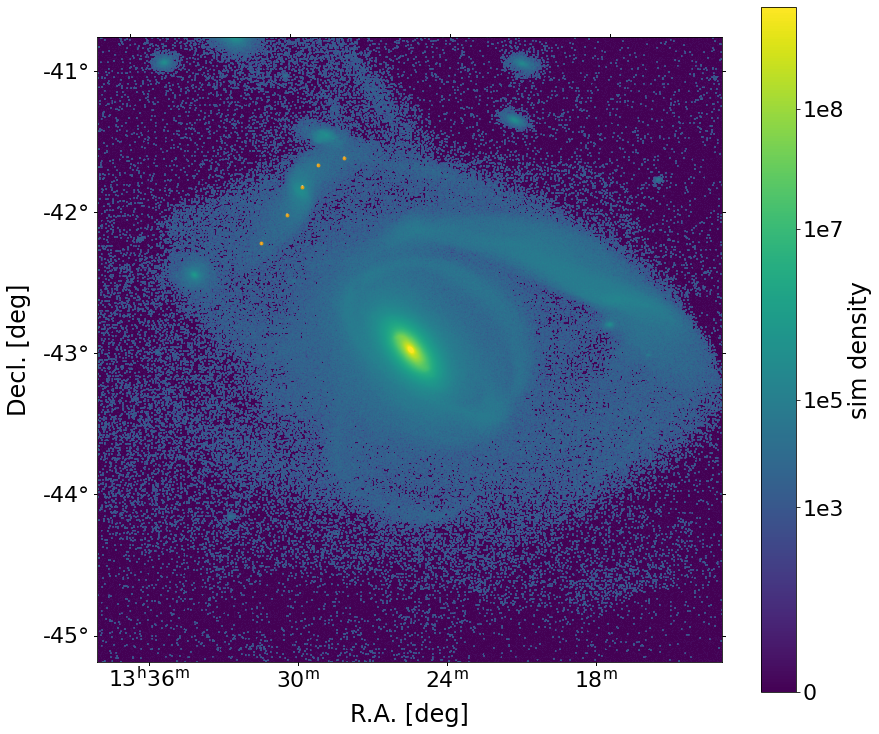

In [730]:
# attempt at making figure just like I do in the Cen A notebook

fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(projection=wcs_helix)
#plt.imshow(h.T, origin='lower',norm=PowerNorm(gamma=0.1),vmin =0, vmax =5e8, aspect='equal', rasterized=True)

cax = ax.imshow(h_new.T, origin='lower',norm=PowerNorm(gamma=0.1),vmin =0, vmax =5e8, aspect='equal', rasterized=True)
plt.errorbar(control_points.ra.deg, control_points.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=6,alpha=0.7,ecolor='white',transform=ax.get_transform('icrs'), rasterized=True)

plt.xlabel(r'R.A. [deg]')
plt.ylabel(r'Decl. [deg]')
#plt.colorbar(label='sim density', ticks = [0,10**3, 10**5, 10**6, 10**8],tick_labels=[],shrink=0.9)
cbar = fig.colorbar(cax,label='sim density', ticks = [0,10**3, 10**5, 10**7, 10**8],shrink=0.9)
cbar.ax.set_yticklabels(['0', '1e3', '1e5', '1e7', '1e8'])  # vertically oriented colorbar

ax.set_ylim([0,799]) #set by pixel scale
ax.set_xlim([799,0]) #set by pixel scale 

In [731]:
np.min(h)/1e9

0.0

In [732]:
def cenA_skyoffset(center_coords , angle):
    """To use this function use data.transform_to(cenA_skyoffset(c_CenA,alpha))"""
    
    offset = SkyOffsetFrame(origin=center_coords, rotation=alpha)
    return offset

In [733]:
def generate_stream(prog_pos, vel, dw3_mass, dw3_b, halo_mass, halo_c,t_integrate, pot):

    """Simulate stream and orbit of progenitor"""
    #should step over these parameters below....
    w0 = gd.PhaseSpacePosition(prog_pos.cartesian.xyz.to(u.kpc),
                            vel )
    #print(w0)
   # pot = gp.NFWPotential.from_M200_c(halo_mass, c=halo_c, units=galactic)
    pot = pot
    
    rnd = np.random.RandomState(seed=42)
    df = gd.mockstream.FardalStreamDF(random_state=rnd)
    gen = gd.MockStreamGenerator(df, gp.Hamiltonian(pot), 
                             progenitor_potential=gp.PlummerPotential(m=dw3_mass, 
                                                                      b=dw3_b, 
                                                                      units=galactic))
    stream_dw3, _ = gen.run(w0, prog_mass=dw3_mass, release_every=3, 
                    dt=-1*u.Myr, n_steps=t_integrate)
    orbit = gp.Hamiltonian(pot).integrate_orbit(w0, dt=-1., n_steps=t_integrate)
    
    return stream_dw3, orbit

In [734]:
# Write function to remove stars from stream

def remove_stars(pot, stream, orbit, prog_m):
    R = orbit.physicsspherical.r
    M_enc = pot.mass_enclosed(orbit.xyz)
    # new step, need to check orbit time 
    # direction here so that it ends up with lower mass 
  #  prog_m_old=prog_m
    steps = nsteps+1
    prog_m_rt = np.linspace(3e7,prog_m.value,steps)*u.Msun
    r_jac = (prog_m_rt / M_enc) ** (1/3) * R
  #  r_jac_old = (prog_m_old / M_enc) ** (1/3) * R
    r_jac_interp = interp1d(orbit.t.to_value(u.Myr), r_jac.to_value(u.pc))
    r_jac_stream = r_jac_interp(stream.release_time.to_value(u.Myr)) * u.pc

    
    r_jac_stream = r_jac_interp(stream.release_time.to_value(u.Myr)) * u.pc
   # _ = stream[r_jac_stream < 3 * u.kpc].plot(marker='o', linewidth=0, s=1.5, alpha=0.2)

    #set some minimu threshold based on r_t at peri, which is the minimum.
    r_thresh =2* 3.316# ~3 arcmin =3.316kpc from Denja 2016 Fig 9

    
    stream_remove = stream[r_jac_stream < r_thresh  * u.kpc]
    
    #maybe also store r_jac, which should have 6000 timesteps
    # this way I can find it later for the plot where I have tidal radius in label 
    
    return stream_remove, r_jac

In [735]:
step_size = 0.01 #deg for interpolator

def control_interpolate(x, y , steps):
  
    f = scipy.interpolate.interp1d(x= x, y = y)

    lon_new = np.arange(np.min(x), (np.max(x)-steps), steps)
    lat_new = f(lon_new)
    return lon_new,lat_new

## Set up potential

In [736]:
# fiducial halo with M_enxlosed from GCs
hub = cosmo.h #hubble constant
m_halo = 9.4*10**12* u.Msun #Mvir
c_halo = 10**(-0.097* np.log10(m_halo/(hub**(-1)*u.Msun))+2.1478294922830115)


pot_CenA = gp.CCompositePotential()
# stars in sphere not disk
#pot_CenA['disk'] = gp.HernquistPotential(m=1E11, c=a_hernq , units=galactic) #From K_band Lum
pot_CenA['halo'] = gp.NFWPotential.from_M200_c(m_halo, c=c_halo, units=galactic)

#should be 9.7x10^11 Msun from Woodley+ 2010
print(pot_CenA.mass_enclosed([40,0,0])) 

# for enclosed mass and vcirc
pos_pot = np.zeros((3,500)) * u.kpc
pos_pot[0] = np.logspace(np.log10(20./500.), np.log10(20*500.), pos_pot.shape[1]) * u.kpc

m_profile_cena = pot_CenA.mass_enclosed(pos_pot)
vcirc_cena = pot_CenA.circular_velocity(pos_pot)#density(pos_pot)





[8.91068896e+11] solMass


In [810]:
def plot_streamfit_orbit(sim_stream_lon_inter,sim_stream_lat_inter,\
                        stream_lon, stream_lat,sim_lon_n,sim_lat_n,\
                        c_control_offset_lon, c_control_offset_lat,sigma_n,\
                         lnL, orbit, stream,cena_stream_icrs,lnL_input,vel, verbose, pot,\
                        stream_rt, stream_lon_rt, stream_lat_rt,cena_stream_icrs_rt,\
                         sim_lon_n_rt,sim_lat_n_rt, lnL_rt,r_jac ):
    
    
    colormap2 =  matplotlib.cm.Blues
    cmap=plt.get_cmap("magma_r")
    colormap = matplotlib.cm.BrBG_r#PiYG_r#RdBu_r#magma_r#RdBu#Blues#cool
    fig = plt.figure(figsize=(14,14))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=-0.05)
    #share x only for some subplots 
    
    
    ax1 = fig.add_subplot(221,aspect=2,projection=wcs_helix)
    ax1.imshow(h_new.T, origin='lower',norm=PowerNorm(gamma=0.1),vmin =0, vmax =5e8, aspect='equal', rasterized=True)
    ax1.set_xlabel(r'R.A. [deg]')
    ax1.set_ylabel(r'Decl. [deg]')
    ax1.set_ylim([0,799]) #set by pixel scale
    ax1.set_xlim([799,0]) #set by pixel scale
    cax = ax1.scatter(cena_stream_icrs.ra.degree, cena_stream_icrs.dec.degree,\
             alpha=1, s=4,transform=ax1.get_transform('icrs'), c = cena_stream_icrs.radial_velocity, cmap=colormap,vmin=-320,vmax=320, rasterized=True)

    ax1.errorbar(control_points.ra.deg, control_points.dec.deg,yerr=dec_err_new, xerr=None,\
             fmt='.', color='orange',markersize=6,alpha=0.7,ecolor='white',transform=ax1.get_transform('icrs'), rasterized=True)

    cbar = fig.colorbar(cax,label=r'$v_{r,Dw3} - v_{r,CenA}$ [km/s]',shrink=0.7)

    
    
    ax2 = fig.add_subplot(222,aspect=2,projection=wcs_helix)
    plt.imshow(h_new.T, origin='lower',norm=PowerNorm(gamma=0.1),vmin =0, vmax =5e8, aspect='equal', rasterized=True)
    ax2.set_ylim([0,799]) #set by pixel scale
    ax2.set_xlim([799,0]) #set by pixel scale 

    cax1 = ax2.scatter(cena_stream_icrs.ra.degree, cena_stream_icrs.dec.degree,\
             alpha=1, s=4,transform=ax2.get_transform('icrs'), c = (cena_stream_icrs.distance.value-3800), cmap=cmap, vmin=-100,vmax=100, rasterized=True)
    ax2.set_xlabel(r'RA [deg]')
    ax2.set_ylabel(r'Decl. [deg]')
    cbar = fig.colorbar(cax1,label=r'$d_{Dw3} - d_{CenA}$ [kpc]',shrink=0.7)#, location='bottom')

    
    
    aspect1 = 1
    ax3 = fig.add_subplot(223,aspect=aspect1)
    cmap=plt.get_cmap("magma_r")
    colormap = matplotlib.cm.BrBG_r#PiYG_r#RdBu_r#magma_r#RdBu#Blues#cool
    ax3.scatter(stream_lon, stream_lat,\
            #alpha=0.3, s=3, color='lightcoral', label=r'sim. stream vel$_{\rm Dw3}$ = ' + str(vel.value) +' km/s')
            alpha = 0.8, s=3,  c = cena_stream_icrs.radial_velocity, cmap=colormap,vmin=-320,vmax=320, label=r'sim. ($v_{\phi_1},v_{\phi_2}$) = (' + str(vel[1].value) +',' +str(vel[2].value)+') km/s')

    ax3.plot(sim_stream_lon_inter ,sim_stream_lat_inter,color='grey', label=r'interpolated sim. track')#, d$_{\rm Dw3}$ = ' +str(np.round(lnL_input[0],3))+ ' Mpc')
    
    ax3.scatter(sim_lon_n,sim_lat_n,
            alpha=1, s=16, color='grey', label='evaluation points')


    ax3.errorbar(c_control_offset_lon.deg, c_control_offset_lat.deg,yerr=sigma_n, xerr=None, \
             fmt='.', ecolor='black', color='black',elinewidth=2,markersize=4,label=r'data points, -ln$L$ = ' + str(np.round(-lnL,2)))#,transform=ax.get_transform('icrs'))
    
    ax3.legend( fontsize=14, loc='upper left')
    ax3.set_xlim([-2.7,2.7])
    ax3.set_ylim([-1.5,3.5])
    ax3.set_xlabel(r'$\phi_1$ [deg]')#lon$_{\rm stream}$ [deg]')
    ax3.set_ylabel(r'$\phi_2$ [deg]')#lat$_{\rm stream}$ [deg]')
    
    
    
    
    #add arrow of dw3 direction
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="k")
    a3 = patches.FancyArrowPatch((-0.3, 0.95), (0.3, 0.95),
                             connectionstyle="arc3,rad=-0.5", **kw)
    plt.gca().add_patch(a3)
    
    
    
    
    aspect2 = 35#27
    ax4 = fig.add_subplot(224,aspect=aspect2)
    pos_in_time = np.sqrt(orbit.pos.x**2+orbit.pos.y**2+orbit.pos.z**2)
    peri = np.min(pos_in_time).value
 
    from scipy.signal import find_peaks
    peri_passes = find_peaks(1/pos_in_time,(1/(peri+1)))
   # print('------')
   # print(peri_passes)
    if verbose:
        print('number of peri passes = ' + str(len(peri_passes[0])))
    
    colors = ['palevioletred','lightcoral','lightpink','mistyrose', 'maroon', 'teal', 'darkblue']
    ax4.plot(orbit.t,pos_in_time, label='Dw3 orbit, r_peri = '\
             +str(np.round(peri,1)) +' kpc', color='gray')
    
    if len(peri_passes[0])==1:
        ax4.axvline(-peri_passes[0],color='lightcoral', linestyle='-', \
                    label = r'peri pass: 1, $r_{Jac}$ = ' + str(np.round(r_jac[peri_passes[0][0]],2)))
#                    label='peri pass: 1, r_t = ' + str(np.round(r_tidal[0],2))+ ' kpc')
    if len(peri_passes[0])>1:

        for i in range(len(peri_passes[0])):
            ax4.axvline(-peri_passes[0][i],color=colors[i], linestyle='-', \
                    label=r'peri pass: ' + str(len(peri_passes[0])-i) +', $r_{Jac}$ = ' + str(np.round(r_jac[peri_passes[0][i]],2)))  
#                    label='peri pass: ' + str(len(peri_passes[0])-i) +', r_t = ' + str(np.round(r_tidal[0],2))+ ' kpc')
    ax4.set_xlabel('time [Gyr]')
    ax4.set_xticks([-6000,-5000,-4000,-3000,-2000,-1000,0])
    ax4.set_xticklabels(['-6', '-5', '-4', '-3','-2', '-1', '0'])
    #ax2.text(np.min(orbit.t.value) + 200,peri+20,'r_tidal at peri: ' + str(np.round(r_tidal,2)), color ='red', size=18)
    ax4.set_ylabel('$R_{GC}$ [kpc]')
    ax4.set_ylim([np.min(pos_in_time.value)-10,np.max(pos_in_time.value)+70])
    ax4.legend( fontsize=16,  loc='upper left')
    

 
    
    vel_3D = np.round(np.sqrt(vel[0]**2 + (vel[1]**2+ (vel[2]**2))),1).value

#     #fig.tight_layout()
    fig.savefig(plot_path+'stream_-lnL'+str(np.round(-lnL,2))+'_dist'\
                +str(np.round(lnL_input[0],3))+'t_'+str(nsteps/1000)+'Gyr_mhalo_'+\
                str(np.round(pot['halo'].parameters['m'].value/10**12,2))+'e12.pdf', dpi=300)
    
    




In [811]:
c_centroids# =  coord.SkyCoord(control_points[idx_sort])
idx_sort

array([0])

In [812]:
def call_lnL(lnL_input, vel, pot, plot, verbose): #plot = true, false, wrap plot in if statement 
    """

    Function that calculates the lnL of a stream simulation to input control
    data from the Dw3 stream in Cen A

    1. Transforms ICRS data from dw3 stream to skyoffset frame
    2. Generates Dw3 stream and orbit in CenA GC frame
    3. Transforms stream to skyoffset frame centerd on cenA rotated to horizontal stream
    4. Fits ridgeline through stream simulation in skyoffset frame
    5. Evaluates lnL of generated stream compared to control data points
    """
    
    dw3_distance = lnL_input[0]*u.Mpc

    #First use distance to define skycoords of Cen A in ICRS
    #Cen A skypos
    c_CenA = coord.SkyCoord(ra = 201.365063*u.deg, dec =-43.019113*u.deg,\
                        distance = CenA_distance )

    # Ans also the Dw3 in ICRS
    # dwarf pos
   # pos = coord.SkyCoord(ra=202.585167*u.deg, dec=-42.191741*u.deg,\
    #                     distance = dw3_distance)
    
    #pos of FIREDw in ICRS
    pos = coord.SkyCoord(ra=202.4*u.deg, dec=-41.85*u.deg,\
                         distance = dw3_distance)


    # First rotate data points to skyoffset frame
    # taking the [idx_cen] index to sort in RA (before trailing arm was first)
    # the aboce step is important when comparing to sim data points
    #c_centroids =  coord.SkyCoord(centroids[0,:][idx_sort]*u.deg, \
     #                        centroids[1,:][idx_sort]*u.deg)

    c_centroids =  coord.SkyCoord(control_points)

    
    c_control_offset_lon = c_centroids.transform_to\
                        (cenA_skyoffset(c_CenA,angle)).lon
    c_control_offset_lat =  c_centroids.transform_to\
                        (cenA_skyoffset(c_CenA,angle)).lat

    # Define CenA frame
    # Frame to simulate stream in
    # Milky Way is along the z-axis x and y axes are 
    # oriented with the Cen A stream from Dwarf III
    # First need galactocentric frame to simulate stream in
    class CenAGalactocentric(coord.BaseCoordinateFrame):
        """
        Position at the center of Cen A
    
        Milky Way is along the z-axis
        x and y axes are oriented with the Cen A stream from Dwarf III
        
        
        SP checked above, and it seems like it's x and vx that points towards MW
        """

        default_representation = coord.CartesianRepresentation
        default_differential = coord.CartesianDifferential

        # Frame attributes
        CenA_sky_coord = coord.CoordinateAttribute(
            frame=coord.ICRS,
            default=coord.SkyCoord(c_CenA.ra.deg, c_CenA.dec.deg, unit=u.deg)
        )
    
        CenA_distance = coord.QuantityAttribute(
            default=CenA_distance,# * u.Mpc,
            unit=u.Mpc
        )

        alpha = coord.QuantityAttribute(
            default=alpha,
            unit=u.deg
           
        )

    #Don't fully understand if I need the below for the angle, I already do this in the skyoffset frame
    from astropy.coordinates.matrix_utilities import rotation_matrix

    def get_icrs_to_cena_transform(cena_frame, icrs_frame, inverse=False):
        """
        Get the transformation matrix to go from ICRS to Cen A coordinates.
    
        Note: Currently this only does positions correctly
        """
       # print(alpha)
        # Rotation matrix to go from CenA to ICRS
        Rz = rotation_matrix(-cena_frame.CenA_sky_coord.ra, 'z')
        Ry = rotation_matrix(cena_frame.CenA_sky_coord.dec, 'y')
        Rx = rotation_matrix(cena_frame.alpha, 'x')
        R = Rz @ Ry @ Rx
    
        # Positional offset to the center of Cen A (from ICRS)
        dpos = coord.CartesianRepresentation(cena_frame.CenA_distance * [1., 0, 0])

        if inverse:  # Cen A to ICRS
            A = R
            b = (dpos).transform(A)

        else:  # ICRS to Cen A
            A = R.T
            b = -dpos

        return A, b


    @coord.frame_transform_graph.transform(
        coord.transformations.AffineTransform,
        coord.ICRS,
        CenAGalactocentric
    )
    def icrs_to_cena(icrs_coord, cena_frame):
        return get_icrs_to_cena_transform(cena_frame, icrs_coord)


    @coord.frame_transform_graph.transform(
        coord.transformations.AffineTransform,
        CenAGalactocentric,
        coord.ICRS
    )
    def cena_to_icrs(cena_coord, icrs_frame):
        return get_icrs_to_cena_transform(cena_coord, icrs_frame, inverse=True)
    
    
    # Use CenA Galactocentric frame to get stream progentor pos
    dw3_pos_GC = pos.transform_to(CenAGalactocentric())


    #print(vel.shape)
    # Generate stream and orbit of progentiro
    stream, orbit = generate_stream(prog_pos = dw3_pos_GC, vel=vel, dw3_mass=mass, \
                                    dw3_b=b, halo_mass=halo_mass,\
                                    halo_c=halo_c,t_integrate=t_integrate, pot=pot)
 
    
   #stream.plot(alpha=0.3)

#     plt.ylim(-200,200)
 #   print(orbit[-1])
 #   print(orbit[0])
    
    #Transform the stream from Galactic frame to CenA centered and rotated frame
    cena_stream = CenAGalactocentric(stream.pos.with_differentials(stream.vel))
 
    cena_stream_icrs = cena_stream.transform_to(coord.ICRS())
    
  
    #dw3_CenAGC = CenAGalactocentric(stream[4001].pos.with_differentials(stream[4001].vel))
    #dw3_icrs= dw3_CenAGC.transform_to(coord.ICRS())

    stream_lon = cena_stream_icrs.transform_to(cenA_skyoffset(center_coords = \
                                                              c_CenA, angle = angle)).lon
    stream_lat = cena_stream_icrs.transform_to(cenA_skyoffset(center_coords = \
                                                              c_CenA, angle = angle)).lat
   
    #print(stream_lat)
    # Fit ridgeline through stream for stream to data comparison
    # bin size
    d_xlon = 0.15 #deg

    xlon = np.arange(np.min(stream_lon.deg), np.max(stream_lon.deg), d_xlon)
    #print(xlon)
    #print(np.max(stream_lon.deg) - np.min(stream_lon.deg))
    
    #w e need a better way to skip recent infall but for now, if there aren't
    # if the extent of sim is smaller than interpol step, for now make step smaller
    # so we can visualize the stream and not fail/skip here ( although lnL will be -inf)
    if ( np.abs(np.max(stream_lon.deg) - np.min(stream_lon.deg))/2 ) < d_xlon:
        d_xlon = d_xlon/100
        xlon = np.arange(np.min(stream_lon.deg), np.max(stream_lon.deg), d_xlon)
        if verbose:
            print("Warning: interpolation of sim is smaller than " + str(d_xlon) +' deg')
        
        

    #center, bc = bin center
    #else:
    xlon_bc = 0.5*(xlon[1:] + xlon[:-1])
    #print()

    #number of bins 
    Nb = np.size(xlon_bc) 
    ylat_med = np.zeros(Nb)#*u.deg
    #print(Nb)

    for i in range(Nb):
        ind = (stream_lon.value>xlon[i]) & (stream_lon.value<=xlon[i+1])# & tout['grz_mask'] & concave_mask
            #print(ind)
        ylat_med[i] = np.median(stream_lat.value[ind])
            #print(ylat_med)
    
    # Interpolate so I have stream track at each xlon value

    sim_stream_lon_inter ,sim_stream_lat_inter =\
                                control_interpolate(x = xlon_bc, y = ylat_med,\
                                steps = step_size )
    

    
    
    # Now only grab the interpolated stream track at the xlon values of the input data
    idx = np.zeros(len(sim_stream_lon_inter), dtype=bool)
    

    
    #for all interpolated stream star track values, grab data ones
    for i in range(len(sim_stream_lon_inter)): 
        #number of data points
        for j in range(len(c_control_offset_lon.deg)): 
            if np.abs(sim_stream_lon_inter[i] - c_control_offset_lon[j].deg)<step_size/2:
                #these indices are the ones to grab for stream track
                idx[i] = True 
       
    #new points for the simulated stream track at same value as data
    sim_lon_n = sim_stream_lon_inter[idx] 
    sim_lat_n = sim_stream_lat_inter[idx]

    
    # Now compute lnL function
    # We look at difference between simulated stream track and the input data and its 

    sigma_n = 0.01#np.ones(len( c_control_offset_lat.deg))*0.01
    if len(c_control_offset_lat.deg)==len(sim_lat_n):
        #print("true")
        Delta_n = np.abs(c_control_offset_lat.deg - sim_lat_n)
        Chi_2 = np.sum(Delta_n**2)/sigma_n**2
        lnL = -0.5 * (Chi_2)
        if math.isnan(lnL):
            if verbose:
                print('Setting lnL = -inf: NaN in interpolation array')
            lnL = -np.inf
    else: 
        if verbose:
            print("skipping: simulation doesn't cover extent of data points")
            print("try: longer integration time or more massive progenitor")
        lnL = -np.inf
    #the sigma_n is the error in the vertical direction
    # for now they are just all 0.01 deg

    if verbose:
        print('-ln$L$ = ' + str(np.round(-lnL,2)))
    

    #Now also removing stars based on tidal radius
    #Now also removing stars based on tidal radius
 
    stream_rt, r_jac = remove_stars(pot, stream, orbit, prog_m=dw3_mass)
    cena_stream_rt = CenAGalactocentric(stream_rt.pos.with_differentials(stream_rt.vel))
    cena_stream_icrs_rt = cena_stream_rt.transform_to(coord.ICRS())
    stream_lon_rt = cena_stream_icrs_rt.transform_to(cenA_skyoffset(center_coords = \
                                                              c_CenA, angle = angle)).lon
    stream_lat_rt = cena_stream_icrs_rt.transform_to(cenA_skyoffset(center_coords = \
                                                              c_CenA, angle = angle)).lat
    
    if len(stream_lat_rt) == 0:
        
        print('all stars removed in jacobi cut')
        stream_rt=0
        stream_lon_rt=0
        stream_lat_rt=0
        cena_stream_icrs_rt=0
        sim_lon_n_rt =0
        sim_lat_n_rt =0 
        lnL_rt= -np.inf
    else:
        xlon_rt = np.arange(np.min(stream_lon_rt.deg), np.max(stream_lon_rt.deg), d_xlon)
    #Need to evaluate lnL for this new stream too. 

        if ( np.abs(np.max(stream_lon_rt.deg) - np.min(stream_lon_rt.deg))/2 ) < d_xlon:
            d_xlon = d_xlon/100
            xlon_rt = np.arange(np.min(stream_lon_rt.deg), np.max(stream_lon_rt.deg), d_xlon)
            if verbose:
                print("Warning: interpolation of sim is smaller than " + str(d_xlon) +' deg')
        

        #center, bc = bin center
        #else:
        xlon_bc_rt = 0.5*(xlon_rt[1:] + xlon_rt[:-1])
        #print()

        #number of bins 
        Nb_rt = np.size(xlon_bc_rt) 
        ylat_med_rt = np.zeros(Nb_rt)#*u.deg
        #print(Nb)

        for i in range(Nb_rt):
            ind_rt = (stream_lon_rt.value>xlon_rt[i]) & (stream_lon_rt.value<=xlon_rt[i+1])# & tout['grz_mask'] & concave_mask
            #print(ind)
            ylat_med_rt[i] = np.median(stream_lat_rt.value[ind_rt])
            #print(ylat_med)
    
        # Interpolate so I have stream track at each xlon value

        sim_stream_lon_inter_rt ,sim_stream_lat_inter_rt =\
                                control_interpolate(x = xlon_bc_rt, y = ylat_med_rt,\
                                steps = step_size )
    
    # Now only grab the interpolated stream track at the xlon values of the input data
        idx_rt = np.zeros(len(sim_stream_lon_inter_rt), dtype=bool)

        #for all interpolated stream star track values, grab data ones
        for i in range(len(sim_stream_lon_inter_rt)): 
        #number of data points
            for j in range(len(c_control_offset_lon.deg)): 
                if np.abs(sim_stream_lon_inter_rt[i] - c_control_offset_lon[j].deg)<step_size/2:
                    #these indices are the ones to grab for stream track
                    idx_rt[i] = True 
       
        #new points for the simulated stream track at same value as data
        sim_lon_n_rt = sim_stream_lon_inter_rt[idx_rt] 
        sim_lat_n_rt = sim_stream_lat_inter_rt[idx_rt]
    
        # Now compute lnL function
        # We look at difference between simulated stream track and the input data and its 

        sigma_n = 0.01#np.ones(len( c_control_offset_lat.deg))*0.01
        if len(c_control_offset_lat.deg)==len(sim_lat_n_rt):
        #print("true")
            Delta_n_rt = np.abs(c_control_offset_lat.deg - sim_lat_n_rt)

            Chi_2_rt = np.sum(Delta_n_rt**2)/sigma_n**2 
            lnL_rt = -0.5 * (Chi_2_rt)
            if math.isnan(lnL_rt):
                if verbose:
                    print('Removed stars: Setting lnL = -inf: NaN in interpolation array')
                lnL_rt = -np.inf
        else: 
            if verbose:
                print("Removed stars: skipping: simulation doesn't cover extent of data points")
                print("Removed stars: try: longer integration time or more massive progenitor")
            lnL_rt = -np.inf
    #the sigma_n is the error in the vertical direction
    # for now they are just all 0.01 deg

        if verbose:
            print('Removed stars: -ln$L$ = ' + str(np.round(-lnL_rt,2)))
    

    
    

    # I also want to grab radial velocity at each control poitn in longitude 
    # such that I can plot vrad gradient vs longitude for each halo mass. 
    # Should be similar as above for sim control points
    # cena_stream_icrs.radial_velocity
    #number of bins 
    #Nb = np.size(xlon_bc) 
    yvrad_med = np.zeros(Nb)#*u.deg
    ydist_med = np.zeros(Nb)#*u.deg
    for i in range(Nb):
        ind = (stream_lon_rt.value>xlon[i]) & (stream_lon_rt.value<=xlon[i+1])# & tout['grz_mask'] & concave_mask
            #print(ind)
        yvrad_med[i] = np.median(cena_stream_icrs_rt.radial_velocity.value[ind])
        ydist_med[i] = np.median(cena_stream_icrs_rt.distance.value[ind])
    
    # Interpolate so I have stream track at each xlon value
    sim_stream_lon_inter_vrad ,sim_stream_lat_inter_vrad  =\
                                control_interpolate(x = xlon_bc, y = yvrad_med,\
                                steps = step_size )
    
    # Now only grab the interpolated stream track at the xlon values of the input data
    # use same idx as in above.
       
    #new points for the simulated stream track at same value as data
    sim_lon_vrad_n = sim_stream_lon_inter_vrad[idx] 
    sim_lat_vrad_n = sim_stream_lat_inter_vrad[idx]
    vrad_gradient = np.array([sim_lon_vrad_n ,sim_lat_vrad_n])
    if verbose:
        print('----vrad gradient----')
        print(str(np.min(vrad_gradient[1]))+ ' km/s')
        print(str(np.max(vrad_gradient[1])) +' km/s')
        
   
    # Interpolate so I have stream track at each xlon value
    sim_stream_lon_inter_dist ,sim_stream_lat_inter_dist  =\
                                control_interpolate(x = xlon_bc, y = ydist_med,\
                                steps = step_size )
    sim_lon_dist_n = sim_stream_lon_inter_dist[idx] 
    sim_lat_dist_n = sim_stream_lat_inter_dist[idx]
    dist_gradient = np.array([sim_lon_dist_n ,sim_lat_dist_n])
    if verbose:
        print('----dist gradient----')
        print(str(np.min(dist_gradient[1]) - CenA_distance.value*1000)+' kpc')
        print(str(np.max(dist_gradient[1]) - CenA_distance.value*1000)+ ' kpc')
    
    #Takes more time with this step, don't always need them 
    if verbose:
        np.save(plot_path+'vrad_gradient/vrad_mhalo'+str(np.round(pot['halo'].parameters['m'].value/10e12,2))+'e12.npy',vrad_gradient )
        np.save(plot_path+'vrad_gradient/dist_mhalo'+str(np.round(pot['halo'].parameters['m'].value/10e12,2))+'e12.npy',dist_gradient )


    
  

    #Produce final output plot
    # should only plot if not - inf?? 
    #uncomment for now
    if plot:
            plot_streamfit_orbit(sim_stream_lon_inter,sim_stream_lat_inter,\
                           stream_lon, stream_lat,sim_lon_n,sim_lat_n,\
                            c_control_offset_lon, c_control_offset_lat,sigma_n,lnL, orbit,\
                             stream, cena_stream_icrs, lnL_input,vel,verbose, pot, \
                                 stream_rt, stream_lon_rt, stream_lat_rt,cena_stream_icrs_rt,\
                                 sim_lon_n_rt ,sim_lat_n_rt, lnL_rt, r_jac )
    if verbose and  plot:
        print("plot saved in: " + str(plot_path))
  
   # return -lnL, -lnL_rt#, stream, orbit
   # return -lnL, -lnL_rt, stream, orbit
    return  -lnL, -lnL_rt

# Input

In [813]:
# Input

# distance to CenA
CenA_distance = 3.8 * u.Mpc# 3.8*u.Mpc
FIREDw_distance = 3.88 * u.Mpc# #problem: right now coordinate frame shifts with CenA distance

#rotation to horizontal stream
alpha = 30.76 * u.deg# 50 * u.deg

#dwarf properties
FIREDw_mass = 1e8*u.Msun #1.5e6 * u.Msun
FIREDw_b = 2.5 * u.kpc

#dw3_vel =[19,400,50]*u.km/u.s
FIREDw_vel =[19,250,0]*u.km/u.s

nsteps = 4000 #Myr


### Now make these globals instead
# Can change back by uncommenting the run call and commented variables in call_lnL function
#data = centroids
angle = alpha
#distance = CenA_distance,
#dw_distance= dw3_distance
vel = FIREDw_vel 
mass = FIREDw_mass                
b = FIREDw_b
halo_mass = m_halo
halo_c = c_halo          
t_integrate = nsteps



-ln$L$ = 0.23
Removed stars: -ln$L$ = 0.23
----vrad gradient----
-74.24354822720336 km/s
80.32139747581894 km/s
----dist gradient----
70.84522031929919 kpc
83.60461304335558 kpc


/Users/spearson/opt/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


number of peri passes = 3
plot saved in: /Users/spearson/Desktop/Research/FIREStreams/plots/


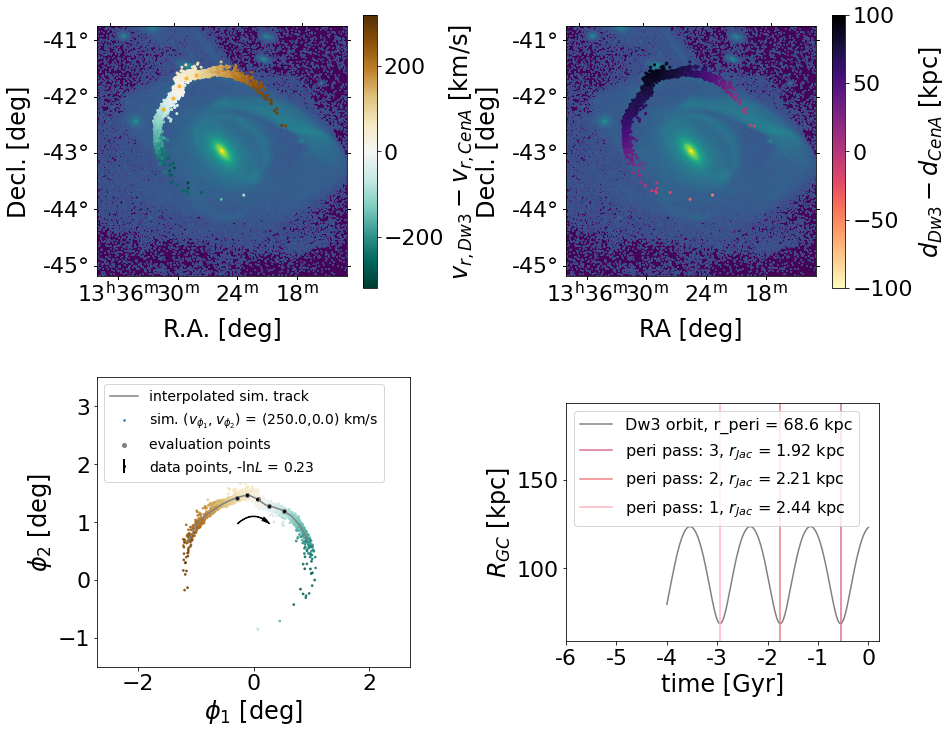

In [814]:

ll_input1 =3.88#*u.Mpc#8#3.633#3.88#63#3.87#*u.Mpc now adding this within function


lnL_input = np.array([ll_input1])#,ll_input2])


lntest,lnrttest = call_lnL(lnL_input, vel, pot=pot_CenA ,plot=True, verbose=True)




In [815]:
#Control points aren't rotated directly
#stream is rotated in top panel but should not be 
# data is rotated in top panel but should not be 